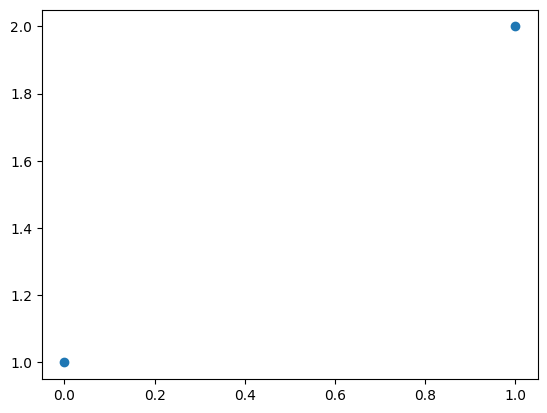

In [1]:
import sys
sys.path.append('f:/seismic/code/core')
sys.path.append('/seismic/code/core')
sys.path.append('/kaggle/input/my-seis-library/')
import kaggle_support as kgs
import importlib
import numpy as np
import matplotlib.pyplot as plt
import glob
import copy
import os
#import seis_forward
#import seis_test
plt.scatter([0,1],[1,2])
#fls.download_kaggle_dataset('jeroencottaar/byu-many-models-2/', fls.result_dir + '/many_full_res/')

In [2]:
importlib.reload(kgs)
data=kgs.load_all_train_data()
print(len(data))
for d in data:
    d.check_constraints()

10000


In [6]:
import cupy as cp
for d in data[::100]:
    d.load_to_memory()
    print(d.family, cp.mean(cp.abs(d.velocity.data-cp.round(d.velocity.data))))
    d.unload()

CurveFault_A 0.01575668646364796
CurveFault_A 0.021186274314413264
CurveFault_A 0.022027961575255103
CurveFault_A 0.023731664540816325
CurveFault_A 0.019734036192602042
CurveFault_A 0.042053571428571426
CurveFault_A 0.049142468510841836
CurveFault_A 0.04779740314094388
CurveFault_A 0.030750707509566325
CurveFault_A 0.04303705955038265
CurveFault_B 0.0
CurveFault_B 0.0
CurveFault_B 0.0
CurveFault_B 0.0
CurveFault_B 0.0
CurveFault_B 0.0
CurveFault_B 0.0
CurveFault_B 0.0
CurveFault_B 0.0
CurveFault_B 0.0
CurveVel_A 0.0
CurveVel_A 0.0
CurveVel_A 0.0
CurveVel_A 0.0
CurveVel_A 0.0
CurveVel_A 0.0
CurveVel_A 0.0
CurveVel_A 0.0
CurveVel_A 0.0
CurveVel_A 0.0
CurveVel_B 0.0
CurveVel_B 0.0
CurveVel_B 0.0
CurveVel_B 0.0
CurveVel_B 0.0
CurveVel_B 0.0
CurveVel_B 0.0
CurveVel_B 0.0
CurveVel_B 0.0
CurveVel_B 0.0
FlatFault_A 0.01444271165497449
FlatFault_A 0.025635712292729592
FlatFault_A 0.01683803013392857
FlatFault_A 0.011267538265306123
FlatFault_A 0.03001773756377551
FlatFault_A 0.03391242825255102